In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import os
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   horizontal_flip=True,
                                   zoom_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                   )
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/VietNam Medicinal Plant/train",target_size=(150, 150),
                                                   batch_size= 128,
                                                   class_mode='categorical',
                                                   shuffle=True,
                                                   )

test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/VietNam Medicinal Plant/test",
                                                          target_size = (150,150),
                                                          batch_size = 128,
                                                          )

Found 12000 images belonging to 200 classes.
Found 8000 images belonging to 200 classes.


In [ ]:
x_train, y_train = next(train_generator)
x_test, y_test  = next(test_generator)

In [ ]:
test_filepath = []
for filepath in test_generator.filepaths:
    filepath = filepath.replace('\\', '/')
    test_filepath.append(filepath)

In [ ]:
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(include_top=False,
                      weights='imagenet',
                      input_shape=(150, 150, 3))

#base_model.summary()
x = base_model.layers[-1].output
x = Dropout(0.3)(x)
# x = Conv2D(200, 3, strides = (1,1), activation='softmax')(x)
x = Conv2D(64, 3, strides = (1,1), activation='softmax')(x)
predictions = Flatten()(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# from tensorflow.keras.applications import Xception

# base_model = Xception(include_top=False,
#                       weights='imagenet',
#                       input_shape=(150, 150, 3))
# #base_model.summary()
# x = base_model.layers[-1].output
# x = Dropout(0.3)(x)
# x = Conv2D(200, 5, strides = (1,1), activation='softmax')(x)
# predictions = Flatten()(x)

# model1 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# from tensorflow.keras.applications import ResNet50

# base_model = ResNet50(include_top=False,
#                       weights='imagenet',
#                       input_shape=(150, 150, 3))
# #base_model.summary()
# x = base_model.layers[-1].output
# x = Dropout(0.3)(x)
# x = Conv2D(200, 5, strides = (1,1), activation='softmax')(x)
# predictions = Flatten()(x)

# model1 = Model(inputs=base_model.input, outputs=predictions)

94773248/94765736 [==============================] - 12s 0us/step


In [ ]:
from tensorflow.keras.optimizers import RMSprop
for layeR in base_model.layers:
    layeR.trainable = False

for layer in base_model.layers[-8:]:
    layer.trainable = True

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [ ]:
model1.compile(optimizer = RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model1.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 10,
)

Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 6.0169 - accuracy: 0.1953 

UnknownError: ignored

In [ ]:
model1.save('resnet')

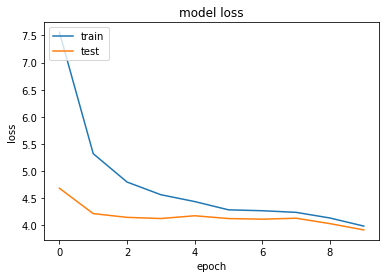

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

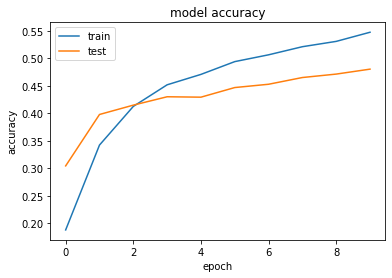

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_acc.png')

In [ ]:
url = 'E:/SPIT/XAI/VietNam Medicinal Plant/test/Aloe_vera/8.jpg'
url = 'E:/SPIT/XAI/VietNam Medicinal Plant/train/Agave_americana/5.jpg'
def transform_img_fn_ori(url):

    img = skimage.io.imread(url)
    img = skimage.transform.resize(img, (150,150))
    img = (img - 0.5)*2
    img = np.expand_dims(img, axis=0)
    preds = model1.predict(img)
#     for i in decode_predictions(preds)[0]:
#         print(i)
    return img

In [ ]:
import skimage
images_inc_im = transform_img_fn_ori(url)

In [ ]:
import lime
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation= explainer.explain_instance(images_inc_im[0].astype('double'), model1.predict,  top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


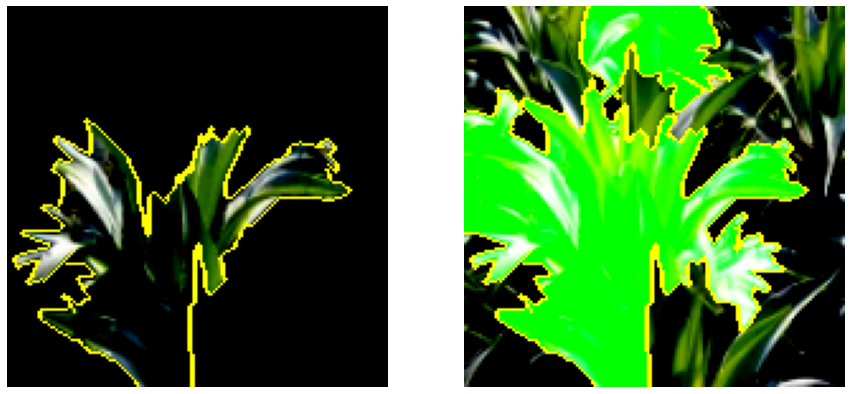

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

plt.savefig('mask_default_xxx.png')